# Long Short-Term Memory (LSTM)

Below is a basic application of the LSTM module in Pytorch.

Using device: cuda


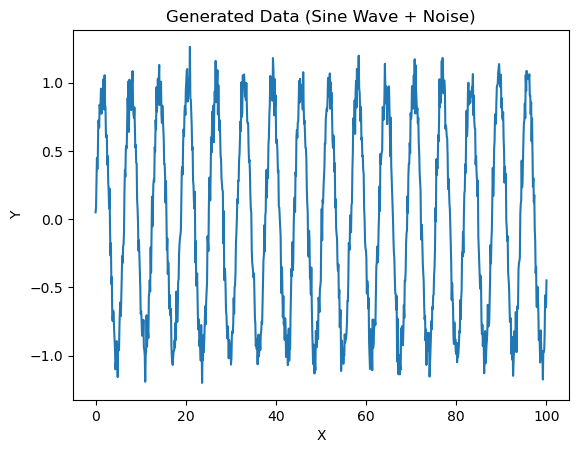

Epoch 1/200, Loss: 0.4460
Epoch 3/200, Loss: 0.4165
Epoch 5/200, Loss: 0.3878
Epoch 7/200, Loss: 0.3594
Epoch 9/200, Loss: 0.3307
Epoch 11/200, Loss: 0.3014
Epoch 13/200, Loss: 0.2708
Epoch 15/200, Loss: 0.2385
Epoch 17/200, Loss: 0.2040
Epoch 19/200, Loss: 0.1669
Epoch 21/200, Loss: 0.1277
Epoch 23/200, Loss: 0.0890
Epoch 25/200, Loss: 0.0616
Epoch 27/200, Loss: 0.0761
Epoch 29/200, Loss: 0.0870
Epoch 31/200, Loss: 0.0680
Epoch 33/200, Loss: 0.0570
Epoch 35/200, Loss: 0.0561
Epoch 37/200, Loss: 0.0580
Epoch 39/200, Loss: 0.0592
Epoch 41/200, Loss: 0.0585
Epoch 43/200, Loss: 0.0561
Epoch 45/200, Loss: 0.0528
Epoch 47/200, Loss: 0.0496
Epoch 49/200, Loss: 0.0474
Epoch 51/200, Loss: 0.0464
Epoch 53/200, Loss: 0.0461
Epoch 55/200, Loss: 0.0453
Epoch 57/200, Loss: 0.0437
Epoch 59/200, Loss: 0.0418
Epoch 61/200, Loss: 0.0402
Epoch 63/200, Loss: 0.0390
Epoch 65/200, Loss: 0.0381
Epoch 67/200, Loss: 0.0371
Epoch 69/200, Loss: 0.0358
Epoch 71/200, Loss: 0.0344
Epoch 73/200, Loss: 0.0331
Epoch 

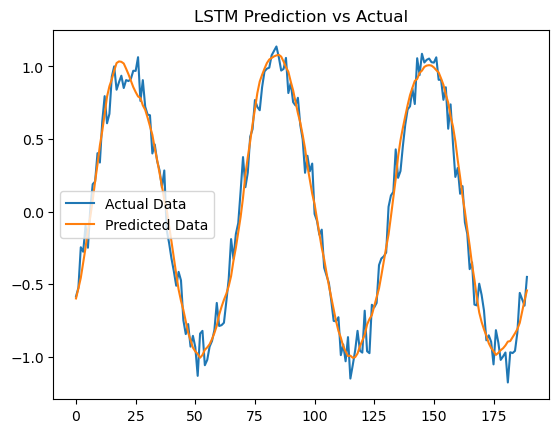

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Set Random Seed for reproducibility
seed = 42

# Set seed for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Print the available GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


# Generate dummy data: Let's simulate a sine wave for this example
def generate_data(seq_length=1000):
    x = np.linspace(0, 100, seq_length)
    y = np.sin(x) + np.random.normal(scale=0.1, size=seq_length)  # sine wave with noise
    return x, y

# Prepare the data
x, y = generate_data()

# Visualize the data
plt.plot(x, y)
plt.title('Generated Data (Sine Wave + Noise)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Normalize the data for better training of the LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Convert the data into sequences for LSTM
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(len(data) - seq_length):
        x_data.append(data[i:i+seq_length])
        y_data.append(data[i+seq_length])
    return np.array(x_data), np.array(y_data)

# Create sequences
seq_length = 50
x_data, y_data = create_sequences(y_scaled, seq_length)

# Reshape data for LSTM input: (samples, time steps, features)
x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))

# Split data into training and test sets
train_size = int(len(x_data) * 0.8)
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# Convert the data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1, :])  # Use the last LSTM output for prediction
        return predictions

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size=1, hidden_layer_size=50, output_size=1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(x_train_tensor)
    
    # Compute the loss
    loss = loss_function(y_pred, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 2 == 0:  # Print every 2 epochs
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test_tensor)

# Inverse scaling to get the actual values back
y_test_pred = scaler.inverse_transform(y_test_pred.numpy())
y_test_actual = scaler.inverse_transform(y_test_tensor.numpy())

# Plot results
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual Data')
plt.plot(range(len(y_test_pred)), y_test_pred, label='Predicted Data')
plt.title('LSTM Prediction vs Actual')
plt.legend()
plt.show()